# Capacity prediction

## Notebook 4: Regression Model 

**Author:** ACG  
**Date:** `2024/06`  
**Version:** 1.0  

---

### Table of Contents
1. [Linear Regression](#linear-regression)
2. [Tree Regression](#tree-regression)
3. [XGBoost](#xgb-regression)

In [3]:
import sys
sys.path.append('..')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from utils.properties import *
import matplotlib.pyplot as plt
import seaborn as sbn

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
seed = 1862

## Import Dataset

In [5]:
df = pd.read_csv(DATASET_FINAL, sep=';')
df_features = df.drop(['capacity'], axis=1)
df_target = df['capacity']

In [6]:
df_target.describe()

count    588.000000
mean      32.005102
std        7.193479
min       15.000000
25%       26.000000
50%       32.000000
75%       37.000000
max       53.000000
Name: capacity, dtype: float64

In [7]:
df.isna().sum()

sector_area                   0
lowest_bound                  0
num_airblocks_avg             0
attitude_cruise_cruise        0
avg_nFlights                  0
median_complexity             0
std_complexity                0
max_harmonic_complexity       0
median_harmonic_complexity    0
std_harmonic_complexity       0
avg_occ_w5                    0
avg_ent_w5                    0
avg_occ_w10                   0
avg_ent_w60                   0
max_occupancyInWindow_10      0
max_entriesInWindow_10        0
max_entriesInWindow_60        0
duration_days                 0
year_from                     0
year_to                       0
atcunit_code                  0
sector_code                   0
ground                        0
ceiling                       0
volume_with_steps             0
is_tma                        0
month_from                    0
day_from                      0
month_to                      0
capacity                      0
dtype: int64

We want to start from a simple regression model, then go up from there.

# 1. Linear Regression <a id="linear-regression"></a>

Because the model parameters have a relatively low correlation with the target (aprox. 40%), it suggests a weak linear correlation. The linear regression model is thus expected to perform the worst. Here we apply feature normalization with StandardScaler, but for the other models it is not required since they are tree based.

In [8]:
from sklearn.linear_model import LinearRegression

## Train

In [9]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)

In [10]:
scaler = StandardScaler()
algorithm = LinearRegression()

model_lr = Pipeline([
    ('scaler', scaler),
    ('algorithm', algorithm)
])
model_lr.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('algorithm', LinearRegression())])

In [11]:
y_pred = model_lr.predict(x_test)
y_train_pred = model_lr.predict(x_train)

## Evaluation

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

In [13]:
print(f"R^2 train: {model_lr.score(x_train,y_train)}")
print(f"R^2 test: {model_lr.score(x_test,y_test)}")

R^2 train: 0.5623012957435604
R^2 test: 0.5303414530621428


As seen from the R squared, the model is capturing some of the target's variance but definetely not a large proportion. The similar results in train and test suggest there is no overfitting, however the low values could possibly represent underfitting, there is certainly room for improvement.

### Error

In [14]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE: train={mean_absolute_error(y_train,y_train_pred)}, test={mae}')
print(f'MSE: train={mean_squared_error(y_train,y_train_pred)}, test={mse}')
print(f'RMSE: train={mean_squared_error(y_train,y_train_pred)**0.5}, test={rmse}')

MAE: train=3.767948670306185, test=3.947825729060713
MSE: train=22.906366266434016, test=22.38426904533728
RMSE: train=4.786059576147586, test=4.731201649194133


On average the predictions with the linear model differ from the actual value by 3.86 units. The RMSE is more sensitive to larger errors then MAE, so a value of 4.66 after taking into account the MAE suggests that there are indeed larger errors, but they aren't extremely large.

### Plots

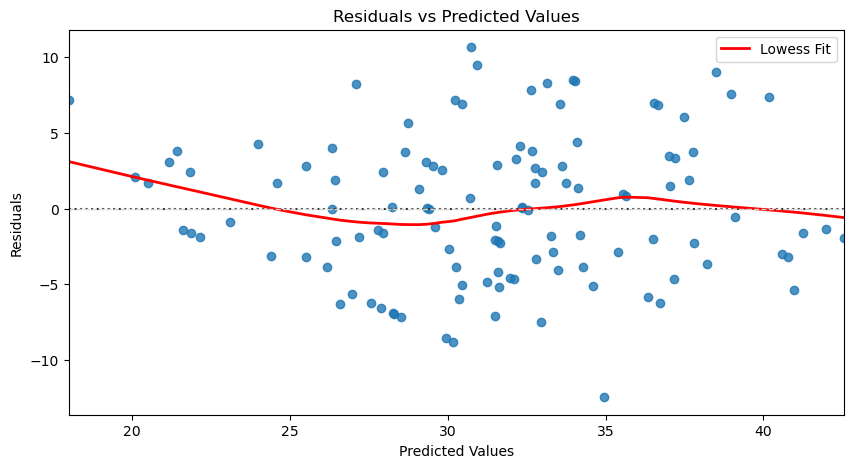

In [15]:
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2, 'label':'Lowess Fit'})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.savefig('../plots/lr_residuals.png') 
plt.show()

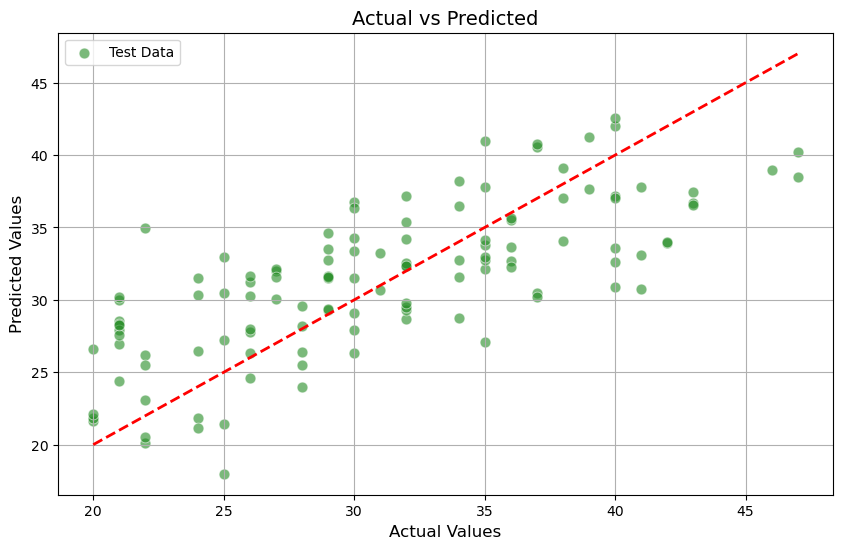

In [16]:
plt.figure(figsize=(10,6))

sbn.scatterplot(x=y_test, y=y_pred, s=60, color='forestgreen', alpha=0.6, label='Test Data')
# sbn.scatterplot(x=y_train, y=y_train_pred, s=60, color='teal', alpha=0.6, label='Train Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('../plots/lr_avp.png') 
plt.show()

# 2. Tree Regression <a id="tree-regression"></a>

In [17]:
from sklearn.tree import DecisionTreeRegressor

In a decision tree model we will need to tune different hyperparameters to achieve optimal results:
1. **max_depth**: the depth of the tree, a greater value means more accuracy but also more computational time.
2. **min_samples_split**: the minimum number of samples required to split a node
3. **criterion**: function used to measure the quality of a split (Squared error, absolute error, etc.)

## Train

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)
tree_base = DecisionTreeRegressor(random_state=seed)

In [22]:
params = {
    'max_depth': [5,8,12,18,25],
    'min_samples_split': [3, 9, 18, 40, 80, 120],
    'criterion': ["squared_error","poisson","absolute_error"]
}
metrics = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [23]:
gs = GridSearchCV(
    estimator=tree_base,
    param_grid=params,
    cv=5,
    scoring=metrics,
    refit='r2'
)
gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1862),
             param_grid={'criterion': ['squared_error', 'poisson',
                                       'absolute_error'],
                         'max_depth': [5, 8, 12, 18, 25],
                         'min_samples_split': [3, 9, 18, 40, 80, 120]},
             refit='r2',
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'mse': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

## Evaluation

In [33]:
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_r2', ascending=False)
print(results.columns)
filter = ['params','mean_test_r2','mean_test_mae','mean_test_mse']
results[filter].head(10)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_split',
       'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae',
       'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae',
       'rank_test_mae', 'split0_test_mse', 'split1_test_mse',
       'split2_test_mse', 'split3_test_mse', 'split4_test_mse',
       'mean_test_mse', 'std_test_mse', 'rank_test_mse', 'split0_test_r2',
       'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2',
       'mean_test_r2', 'std_test_r2', 'rank_test_r2'],
      dtype='object')


,params,mean_test_r2,mean_test_mae,mean_test_mse
3,"{'criterion': 'squared_error', 'max_depth': 5,...",0.512228,3.881940,25.061937
2,"{'criterion': 'squared_error', 'max_depth': 5,...",0.497656,3.879293,25.883872
1,"{'criterion': 'squared_error', 'max_depth': 5,...",0.492850,3.818598,26.111587
45,"{'criterion': 'poisson', 'max_depth': 12, 'min...",0.488877,3.866491,26.387697
58,"{'criterion': 'poisson', 'max_depth': 25, 'min...",0.488613,4.016060,26.241697
52,"{'criterion': 'poisson', 'max_depth': 18, 'min...",0.488613,4.016060,26.241697
46,"{'criterion': 'poisson', 'max_depth': 12, 'min...",0.488613,4.016060,26.241697
57,"{'criterion': 'poisson', 'max_depth': 25, 'min...",0.487067,3.871624,26.471128
51,"{'criterion': 'poisson', 'max_depth': 18, 'min...",0.487067,3.871624,26.471128
0,"{'criterion': 'squared_error', 'max_depth': 5,...",0.484967,3.844001,26.535873


In [39]:
# best GS model by accuracy
best_model_tr = gs.best_estimator_
y_pred = best_model_tr.predict(x_test)
y_pred_train = best_model_tr.predict(x_train)

print(best_model_tr)
print(f"parameters: {gs.best_params_}")
print(f"R squared: {gs.best_score_}")
print(f"R^2 train: {best_model_tr.score(x_train,y_train)}")

DecisionTreeRegressor(max_depth=5, min_samples_split=40, random_state=1862)
parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 40}
R squared: 0.5122277014087525
R^2 train: 0.7174009012716578


In [47]:
# comparison of best candidates
m0 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[0]
m3 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[3]
m1 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[1]
m45 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[45]

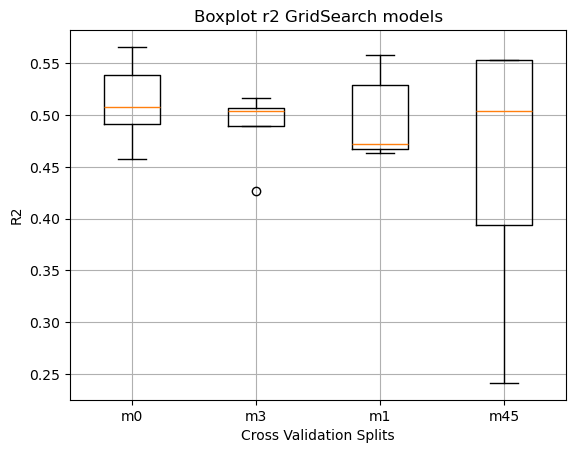

In [48]:
plt.boxplot([m0.values,m3.values,m1.values,m45.values], labels=['m0','m3','m1','m45'])
plt.title('Boxplot r2 GridSearch models')
plt.xlabel('Cross Validation Splits')
plt.ylabel('R2')
plt.grid(True)
plt.savefig('../plots/boxplot_dtr.png') 
plt.show()

The most robust model, the one with less variation, is also the model with the best r2, model at index 3.

### Error

In [53]:
y_pred_train = best_model_tr.predict(x_train)
y_pred_test = best_model_tr.predict(x_test)
rmse_train = mean_squared_error(y_train,y_pred_train) ** 0.5
rmse_test = mean_squared_error(y_test,y_pred_test) ** 0.5
print(f"Train \tR^2={r2_score(y_train, y_pred_train)}, MAE={mean_absolute_error(y_train,y_pred_train)}, RMSE={rmse_train}")
print(f"Test \tR^2={r2_score(y_test,y_pred_test)}, MAE={mean_absolute_error(y_test,y_pred_test)}, RMSE={rmse_test}")

Train 	R^2=0.7174009012716578, MAE=2.9722074087751578, RMSE=3.8457040187651104
Test 	R^2=0.5200934865144186, MAE=3.7204174826387133, RMSE=4.782540601886272


The MAE is slightly lower then the previous model, however the RMSE is slightly higher.

### Plots

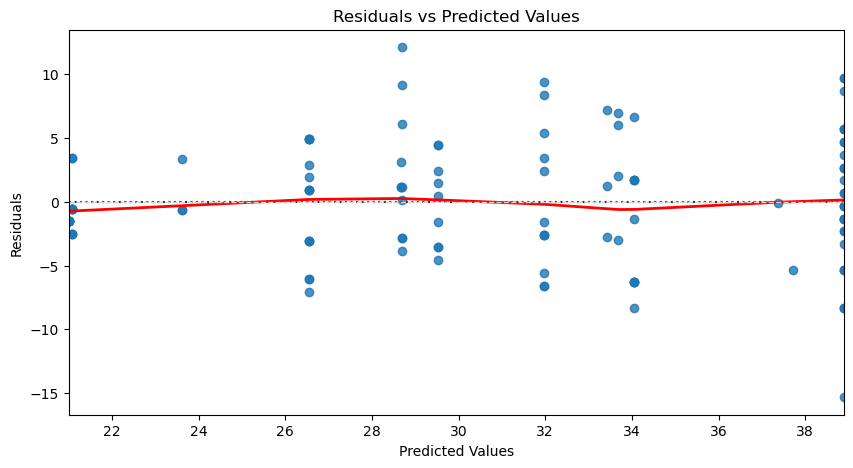

In [54]:
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('../plots/tree_rvp.png') 
plt.show()

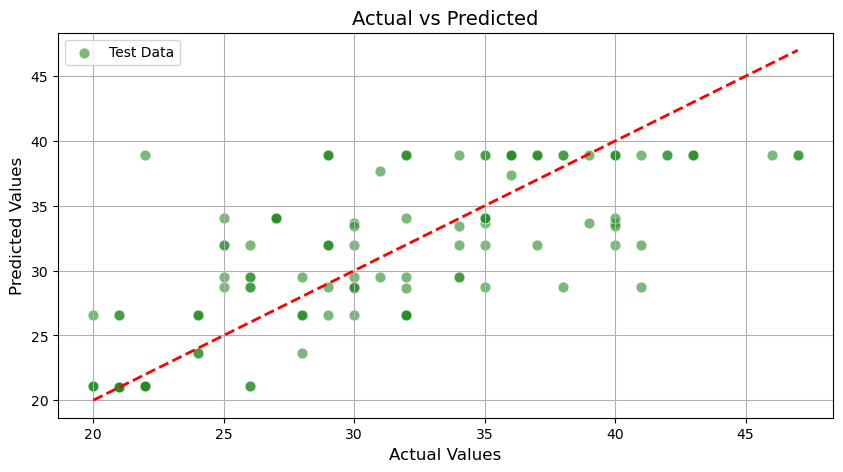

In [51]:
plt.figure(figsize=(10,5))
sbn.scatterplot(x=y_test, y=y_pred, s=60, color='forestgreen', alpha=0.6, label='Test Data')
# sbn.scatterplot(x=y_train, y=y_train_pred, s=60, color='teal', alpha=0.6, label='Train Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('../plots/tree_avp.png') 
plt.show()

# 3. XGBoost <a id="xgb-regression"></a>

In [86]:
from xgboost import XGBRegressor

### Train

We will tune the following parameters:
1. **n_estimators**: the number of trees the algorithm will build
2. **eta**: learning rate, it affects the contribution of each tree to the final model
3. **max_depth**: maximum depth of each tree
4. **alpha**: adds L1 regularization
5. **lambda**: adds L2 regularization

In [122]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)

In [123]:
xgb_base = XGBRegressor(random_state=seed)
params = {
    'n_estimators': [50,100,200],
    'max_depth':[3,5,7],
    'eta': [0.01,0.1,0.4],
    'alpha':[1,2,5,10,12],
    'lambda':[1,2,5,10,12]
}
metrics = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [124]:
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=4,
    scoring=metrics,
    refit='r2'
)
grid_xgb.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    random_state=1862, ...),
             param_grid={'alpha': [1, 2, 5, 10, 12], 'eta': [0.01, 0.1, 0.4],
                         'lambda': [1, 2, 5, 10, 12], 'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             refit='r2',
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'mse': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

### Evaluation

In [125]:
results = pd.DataFrame(grid_xgb.cv_results_).sort_values(by='mean_test_r2', ascending=False)
print(results.columns)
filter = ['params','mean_test_r2','mean_test_mae','mean_test_mse']
results[filter].head(20)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_eta', 'param_lambda', 'param_max_depth',
       'param_n_estimators', 'params', 'split0_test_mae', 'split1_test_mae',
       'split2_test_mae', 'split3_test_mae', 'mean_test_mae', 'std_test_mae',
       'rank_test_mae', 'split0_test_mse', 'split1_test_mse',
       'split2_test_mse', 'split3_test_mse', 'mean_test_mse', 'std_test_mse',
       'rank_test_mse', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2',
       'split3_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'],
      dtype='object')


,params,mean_test_r2,mean_test_mae,mean_test_mse
341,"{'alpha': 5, 'eta': 0.1, 'lambda': 5, 'max_dep...",0.717777,2.783106,14.773097
68,"{'alpha': 1, 'eta': 0.1, 'lambda': 5, 'max_dep...",0.717318,2.772195,14.737492
238,"{'alpha': 2, 'eta': 0.4, 'lambda': 2, 'max_dep...",0.716962,2.797252,14.784994
239,"{'alpha': 2, 'eta': 0.4, 'lambda': 2, 'max_dep...",0.716962,2.797252,14.784994
59,"{'alpha': 1, 'eta': 0.1, 'lambda': 2, 'max_dep...",0.716880,2.760630,14.784520
237,"{'alpha': 2, 'eta': 0.4, 'lambda': 2, 'max_dep...",0.716705,2.798843,14.798458
221,"{'alpha': 2, 'eta': 0.1, 'lambda': 12, 'max_de...",0.716307,2.780770,14.840383
340,"{'alpha': 5, 'eta': 0.1, 'lambda': 5, 'max_dep...",0.715602,2.801039,14.888041
50,"{'alpha': 1, 'eta': 0.1, 'lambda': 1, 'max_dep...",0.714934,2.777553,14.859106
361,"{'alpha': 5, 'eta': 0.4, 'lambda': 1, 'max_dep...",0.714380,2.852573,14.829573


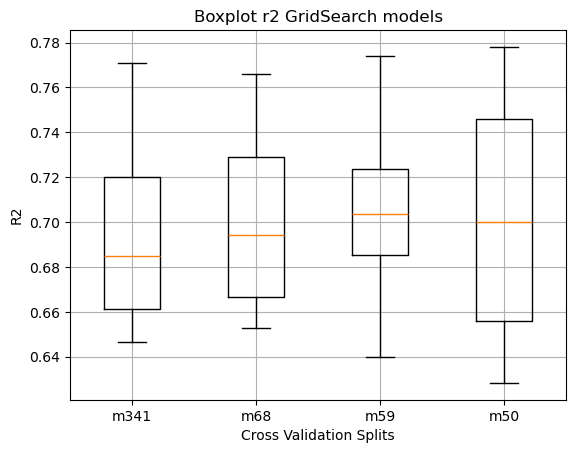

In [131]:
# best candidates
m341 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[341]
m68 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[68]
m59 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[59]
m50 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[50]

plt.boxplot([m1.values,m2.values,m3.values,m4.values], labels=['m341','m68','m59','m50'])
plt.title('Boxplot r2 GridSearch models')
plt.xlabel('Cross Validation Splits')
plt.ylabel('R2')
plt.grid(True)
plt.savefig('../plots/boxplot_xgb.png') 
plt.show()

In [132]:
# best estimator
y_pred_train = grid_xgb.predict(x_train)
y_pred_test = grid_xgb.predict(x_test)

rmse_train = mean_squared_error(y_train,y_pred_train) ** 0.5
rmse_test = mean_squared_error(y_test,y_pred_test) ** 0.5
print(f"Train \tR^2={r2_score(y_train, y_pred_train)}, MAE={mean_absolute_error(y_train,y_pred_train)}, RMSE={rmse_train}")
print(f"Test \tR^2={r2_score(y_test,y_pred_test)}, MAE={mean_absolute_error(y_test,y_pred_test)}, RMSE={rmse_test}")

Train 	R^2=0.99448561668396, MAE=0.3391555704969041, RMSE=0.5372037655510465
Test 	R^2=0.7587511539459229, MAE=2.398314831620556, RMSE=3.3908842640174184


In [133]:
print(grid_xgb.best_estimator_)
print(f"parameters: {grid_xgb.best_params_}")
print(f"R squared: {grid_xgb.best_score_}")

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=5,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)
parameters: {'alpha': 5, 'eta': 0.1, 'lambda': 5, 'max_depth': 7, 'n_estimators': 200}
R squared: 0.717777281999588


In [144]:
# training with m59 params
params = {
    'alpha': results.iloc[59]['param_alpha'],
    'eta': results.iloc[59]['param_eta'],
    'lambda': results.iloc[59]['param_lambda'],
    'max_depth': results.iloc[59]['param_max_depth'],
    'n_estimators': results.iloc[59]['param_n_estimators']
}
xgb59 = XGBRegressor(**params)
xgb59.fit(x_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=1,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100, ...)

In [145]:
y_pred_train = xgb59.predict(x_train)
y_pred_test = xgb59.predict(x_test)

rmse_train = mean_squared_error(y_train,y_pred_train) ** 0.5
rmse_test = mean_squared_error(y_test,y_pred_test) ** 0.5
print(f"Train \tR^2={r2_score(y_train, y_pred_train)}, MAE={mean_absolute_error(y_train,y_pred_train)}, RMSE={rmse_train}")
print(f"Test \tR^2={r2_score(y_test,y_pred_test)}, MAE={mean_absolute_error(y_test,y_pred_test)}, RMSE={rmse_test}")

Train 	R^2=0.970365047454834, MAE=0.9219428813203853, RMSE=1.2453527240674935
Test 	R^2=0.68831866979599, MAE=2.8685088561753096, RMSE=3.8542131855341863


### Plots

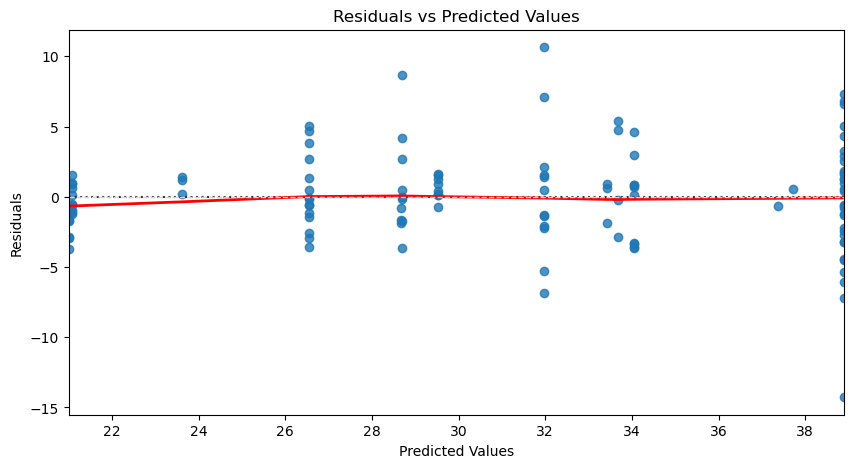

In [129]:
residuals = y_test - y_pred_test
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('../plots/xgb_rvp.png') 
plt.show()

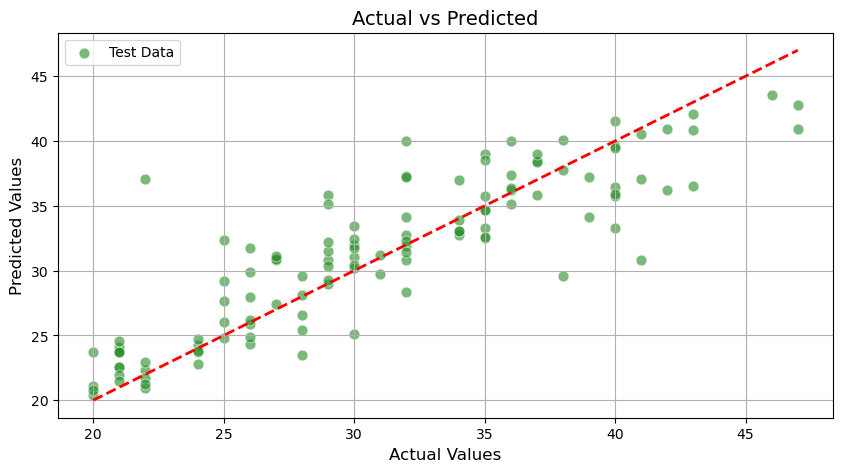

In [130]:
plt.figure(figsize=(10,5))
sbn.scatterplot(x=y_test, y=y_pred_test, s=60, color='forestgreen', alpha=0.6, label='Test Data')
# sbn.scatterplot(x=y_train, y=y_train_pred, s=60, color='teal', alpha=0.6, label='Train Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('../plots/xgb_avp.png') 
plt.show()